In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

from analysis import start_jvm, functional_connectivity, global_signal_regression, artifact_filter

Load data

In [3]:
BOT = 'bot_04'

# Load  bot images
img_before = cv2.cvtColor(cv2.imread(f'bot_images/{BOT}_before_00001.tiff'), cv2.COLOR_BGR2GRAY)
img_after = cv2.cvtColor(cv2.imread(f'bot_images/{BOT}_after_00001.tiff'), cv2.COLOR_BGR2GRAY)

# Load spatial data
pixel_df_before = pd.read_csv('spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
pixel_df_after = pd.read_csv('spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

com_df_before = pd.read_csv('spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)

# Load raw signals
series_raw_before = np.loadtxt('network_inference_data/series_raw/{}_before_series.csv'.format(BOT), delimiter=',')
series_raw_after = np.loadtxt('network_inference_data/series_raw/{}_after_series.csv'.format(BOT), delimiter=',')

series_gsrw_before = np.loadtxt('network_inference_data/series_gsr_whitened/{}_before_entrate.csv'.format(BOT), delimiter=',')
series_gsrw_after = np.loadtxt('network_inference_data/series_gsr_whitened/{}_after_entrate.csv'.format(BOT), delimiter=',')

# FC matrices
fc_before = np.loadtxt('network_inference_data/fc_matrices/{}_before_mimat_w.csv'.format(BOT), delimiter=',')
fc_after = np.loadtxt('network_inference_data/fc_matrices/{}_after_mimat_w.csv'.format(BOT), delimiter=',')

Visualize the raw data

In [4]:
print(series_raw_before.shape)

(269, 245)


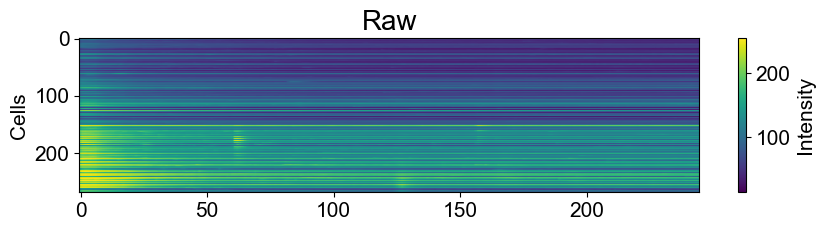

In [5]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_raw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('Raw', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_before_raw.png', dpi=500, bbox_inches='tight', transparent=True)

# ax2 = plt.subplot(gs[1])
# imshow2 = ax2.imshow(series_gsrw_before,aspect='auto')
# plt.colorbar(imshow2, ax=ax2).set_label(label='Intensity',size=15)
# ax2.set_ylabel("Cells", fontsize=15)
# ax2.set_xlabel("Time", fontsize=15)
# ax2.set_title('GSR + whitened')

In [19]:
np.random.seed(10)
before_random_sample = np.random.randint(series_raw_before.shape[0], size=9) # choose 6 random cells ids

In [20]:
before_raw_sample = series_raw_before[before_random_sample,:]

print(before_raw_sample.shape)

(9, 245)


/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/2952128896.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


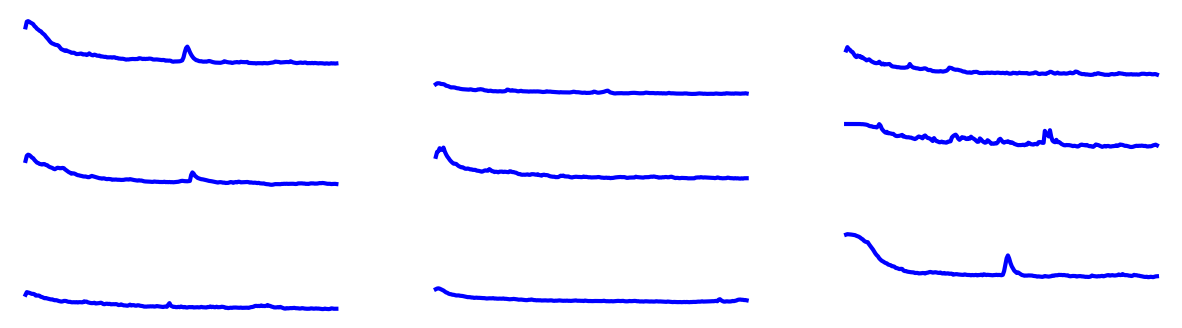

In [34]:
fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)

axes = ax.ravel()


for i in range(len(axes)):

    node_series = before_raw_sample[i,:]

    axes[i].plot(node_series, color='blue', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/before_raw_series.png', dpi=500, bbox_inches='tight')
plt.show()

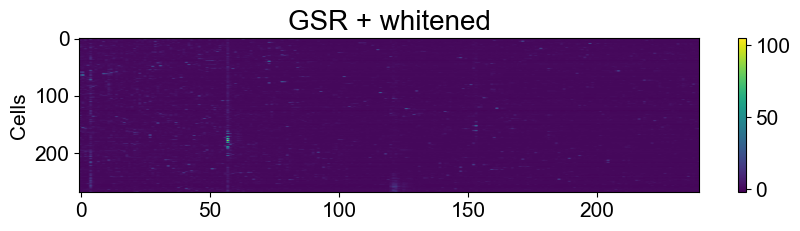

In [7]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_gsrw_before,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('GSR + whitened', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_before_gsr.png', dpi=500, bbox_inches='tight', transparent=True)

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/3388798465.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


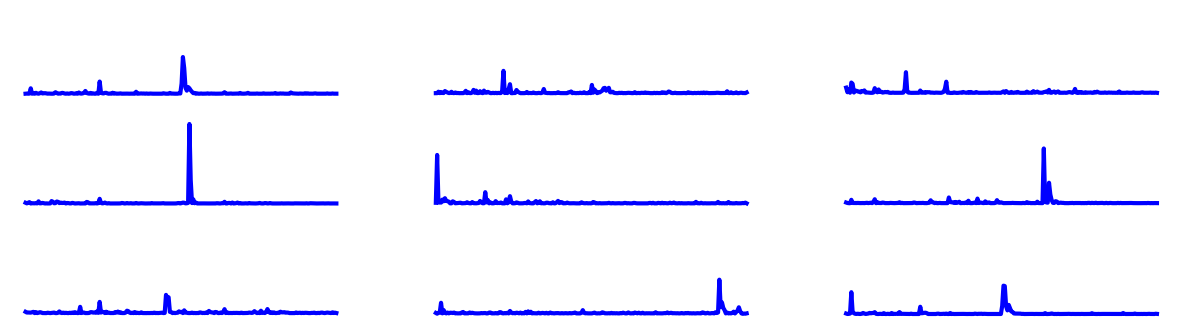

In [37]:
before_gsrw_sample = series_gsrw_before[before_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = before_gsrw_sample[i,:]

    axes[i].plot(node_series, color='blue', linewidth=3)
    axes[i].axis('off')

# plt.suptitle('GSR + whitened')
plt.savefig('../../Desktop/before_gsrw_series.png', dpi=500, bbox_inches='tight')
plt.show()


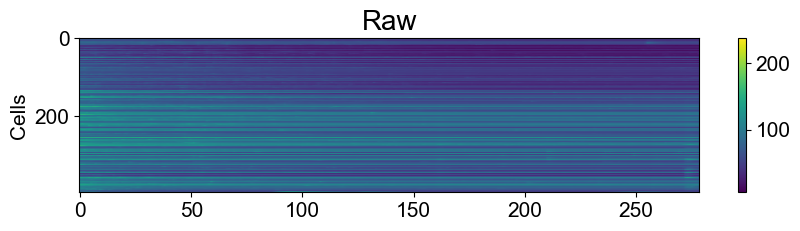

In [8]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_raw_after,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('Raw', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_after_raw.png', dpi=500, bbox_inches='tight', transparent=True)

In [24]:
np.random.seed(10)
after_random_sample = np.random.randint(series_raw_after.shape[0], size=9) # choose 6 random cells ids

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/83353854.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


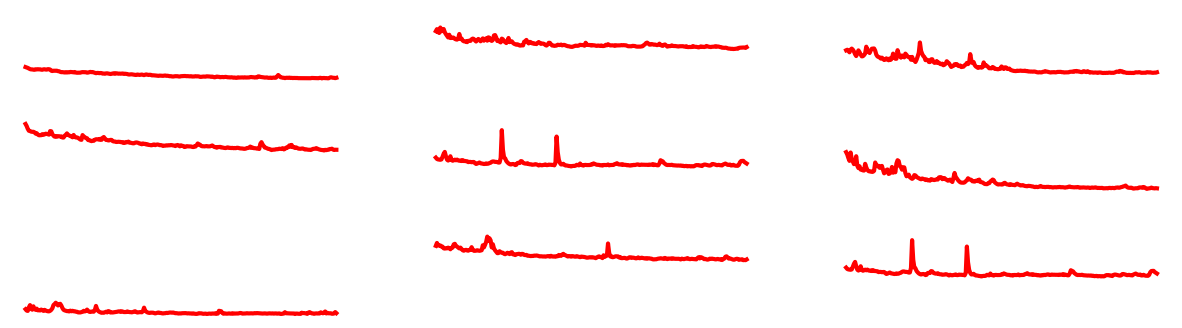

In [38]:
after_raw_sample = series_raw_after[after_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = after_raw_sample[i,:]

    axes[i].plot(node_series, color='red', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/after_raw_series.png', dpi=500, bbox_inches='tight')
plt.show()


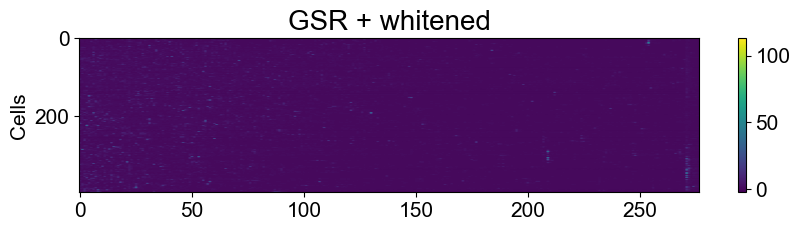

In [9]:
plt.rcParams.update({'font.size': 15, 'font.family': 'arial'})
fig = plt.figure(figsize=(10,2))
gs = plt.GridSpec(1, 1, figure=fig)#, wspace=0.25)

ax1 = plt.subplot(gs[0])
imshow1 = ax1.imshow(series_gsrw_after,aspect='auto') # aspect='auto' autoscales the image to fill up the extent of the figure
cbar = plt.colorbar(imshow1, ax=ax1)
# cbar.set_label(label='Intensity',size=15)

ax1.set_ylabel("Cells", fontsize=15)
# ax1.set_xlabel("Time", fontsize=15)
ax1.set_title('GSR + whitened', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('../../Desktop/timeseries_after_gsr.png', dpi=500, bbox_inches='tight', transparent=True)

/var/folders/_r/tq61fc093tx8v59sfkyt9zhc0000gn/T/ipykernel_5983/2620160699.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.25)


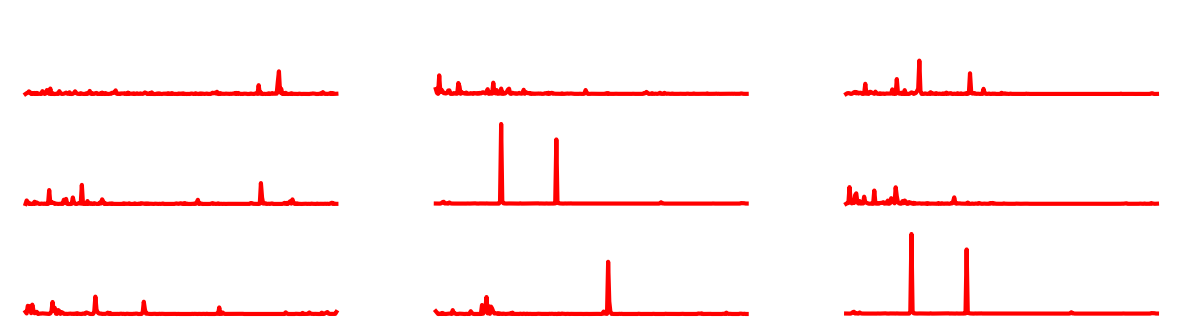

In [39]:
after_gsrw_sample = series_gsrw_after[after_random_sample,:]

fig,ax = plt.subplots(3,3,figsize=(15,4),sharex=True, sharey=True, layout='constrained')
plt.subplots_adjust(hspace=0.25)
axes = ax.ravel()


for i in range(len(axes)):

    node_series = after_gsrw_sample[i,:]

    axes[i].plot(node_series, color='red', linewidth=3)
    axes[i].axis('off')

plt.savefig('../../Desktop/after_gsrw_series.png', dpi=500, bbox_inches='tight')
plt.show()